In [3]:
%matplotlib inline  
# esta linea se usa para poder visualizar gráficos

# ¿Que es esto?

Esto es un jupyter notebook. Es una herramienta para programar en python y otros lenguajes de programación.

Es a la vez una página web y una herramienta para documentar.
Hay celdas de tipo "Markdown" que sirven para escribir lo que se quiera y celdas de tipo "Code" en las que se introduce un código. 

El resultado de ese código se muestra a continuación de dicha celda.

Python es un lenguaje de programación usado para enseñar y en investigación

# Que vamos a hacer?

Hacer un programa que de forma automática haga el proceso de detectar las lineas, medirlas y obtener su orientación y aplique las fórmulas correspondientes para obtener la dieta.

Al principio a partir de una imagen con las lineas dibujadas por una persona, después a partir de una imagen sin retocar por un humano.

Suponiendo que ya sabemos algo de python vamos a continuar.

# Lista de tareas de nuestra aplicación

## Cargar la imagen.
## Procesar la imagen para que solo salgan las lineas dibujadas por el investigador
## Detectar estas líneas
## Extraer las caracteristicas de estas líneas

# Cargar una imagen con skimage

Python es un lenguaje que tiene muchas librerías. Las librerías tienen funciones especiales para trabajar con imágenes, con gráficos, con fórmulas, sonido, webs ...

skimage es una librería para trabajar con imágenes. Las librerías están ordenadas en paquetes y todas las funciones relacionadas están dentro del mismo paquete.
El paquete io (input/output) tiene funciones para leer y escribir imágenes.

(La gente no se aprende todas las funciones, aprende a programar y luego usa google para ver como se usan las funciones).

Pones en google
skimage leer imagen

y sale 
http://scikit-image.org/docs/dev/api/skimage.io.html

Hay una función que se llama imread que recibe el nombre de la imagen y la guarda en una variable.



In [4]:
from skimage import io
#Ponemos la ruta donde sita la imagen a leer 
pathImg="/Users/Ismael/Desktop/TFG_DietaPorDientes/TFG_DietaPorDientes/Imagenes/ATP02 UE4 46_1.jpg"
#pathImg="/Users/Ismael/Desktop/TFG_DietaPorDientes/TrabajosPasadosPorJose/dietaJose/ATP02 UE4 46_1.jpg"
img = io.imread(pathImg)


Para mostrar gráficos se usa la librería matplotlib

Hay una función imshow que muestra una imagen

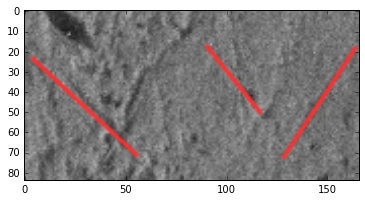

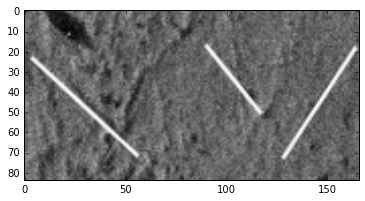

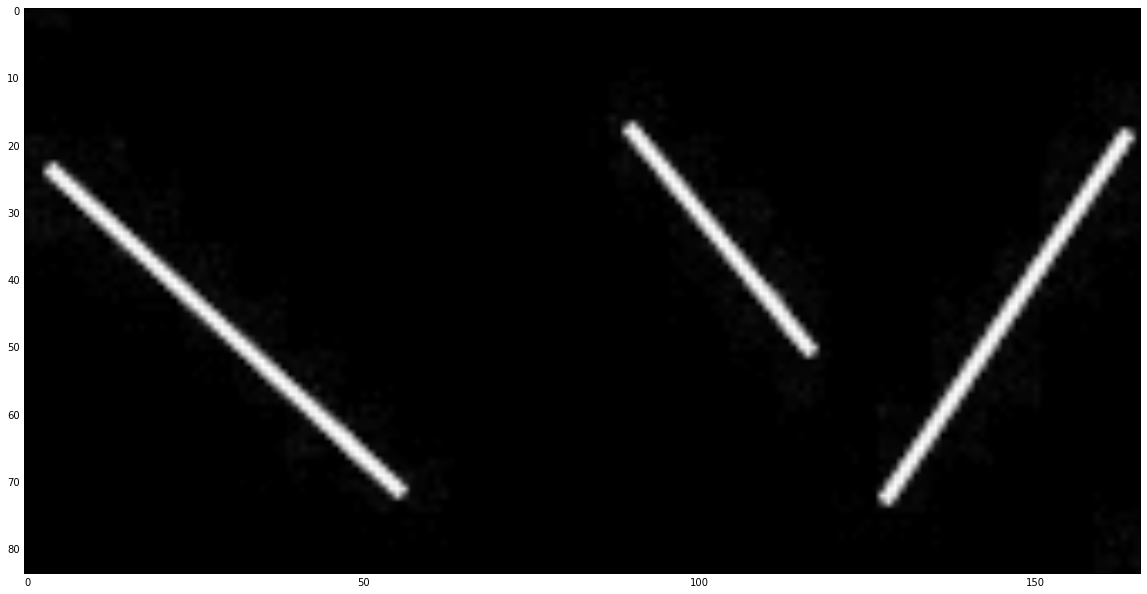

In [5]:
from skimage import img_as_ubyte
from skimage.color import rgb2grey, hsv2rgb

from skimage.color import rgb2hsv
import numpy as np

import matplotlib.pyplot as plt

#Obtenemos el canal rojo de la imagen en RGB
rojo=img[:,:,0]
#Cambiamos el espacio de color a HSV y nos quedamos con el canal correspondiente a la viveza de color
imgHSV=rgb2hsv(img)
colorVivo = imgHSV[:,:,1]

#Mostramos las 3 imagenes (ORIGINAL / CANAL ROJO(RGB) / CANAL VIVEZA (HSV))
plt.figure(figsize=(6, 6)) 
plt.imshow(img, cmap='gray')

plt.figure(figsize=(6, 6)) 
plt.imshow(rojo, cmap='gray')

plt.figure(figsize=(20, 20)) 
plt.imshow(colorVivo, cmap='gray')



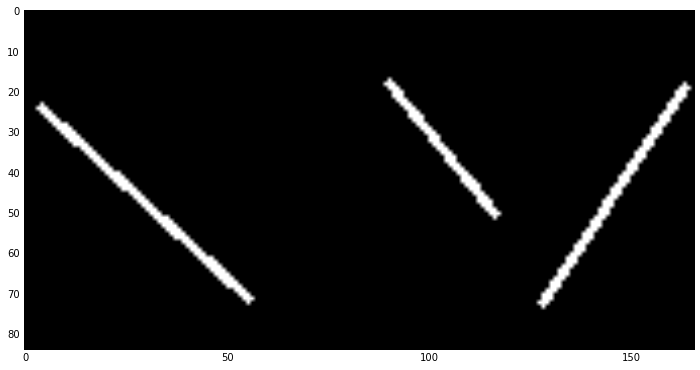

In [4]:
#Vamos a binarizar la imagen usando la funcion threshold_otsu(Dicha funcion lo que hara es combertir colores intermedios 
#a B/W dependiendo del umbral calculado por la funcion antes mencionada y nos quedamos con la imagen binarizada.
from skimage.filters import threshold_otsu

threshold_global_otsu = threshold_otsu(colorVivo)

imgBin = colorVivo >= threshold_global_otsu

plt.figure(figsize=(12, 12)) 
plt.imshow(imgBin, cmap='gray')

2) Quita ruido y skeletoniza

3) Transformada de Hough

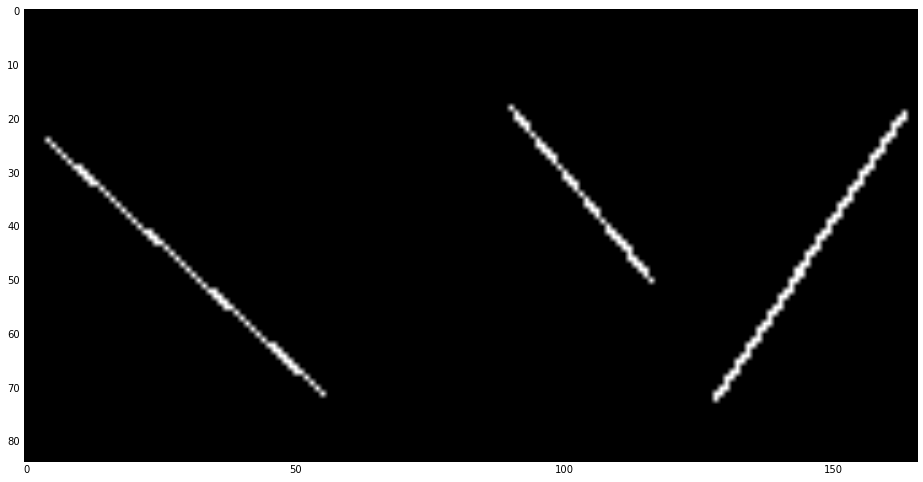

In [5]:
#Para detectar los objetos de la imagen y conseguir unas lineas mas claras para que funcione mas adelante el metodo de deteccion
#vamos a usar las funciones de dilatacion del objeto para hacerlo mas uniforme y un poco mas grande y luego una erosion del 
#objeto para hacerlo mas pequeño y manejable y corregir alguna imperfeccion mas
from skimage.morphology import binary_erosion,rectangle,binary_dilation


selem2 = rectangle(8,1)
selem = rectangle(3,1)

sinRuido = binary_dilation(imgBin,selem2)
sinRuido = binary_erosion(imgBin,selem)


plt.figure(figsize=(16, 16)) 
plt.imshow(sinRuido, cmap='gray')


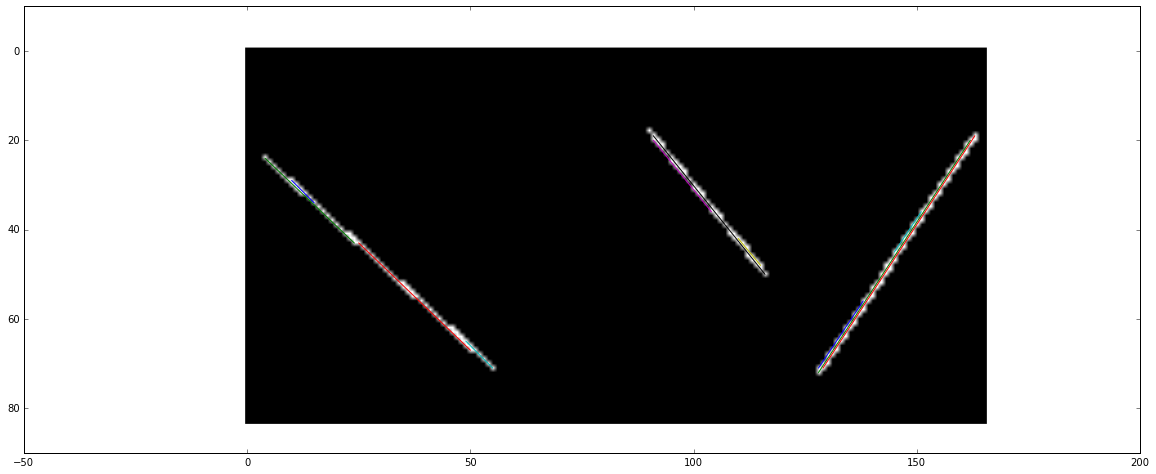

In [6]:
#Para detectar las lineas y uniformar los segmentos para que sean 1 en vez de varios cachos usaremos la transformada de hub
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from skimage import data

import numpy as np
import matplotlib.pyplot as plt


lines = probabilistic_hough_line(sinRuido, threshold=5, line_length=5,
                                 line_gap=3)

lines.sort()

#for line in lines:
#    print(line)


plt.figure(figsize=(20, 20)) 

plt.imshow(sinRuido, cmap=plt.cm.gray)


#Creamos un iterable soble las lineas detectadas y las vamos pintando
for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))


Se obtiene el angulo de los segmentos
Si es muy cercano se haya la distancia entre dos segmentos
Si es muy cercano se combinan

Distancia entre 2 segmentos 
http://stackoverflow.com/questions/2824478/shortest-distance-between-two-line-segments

In [7]:
def segmentsDistance(seg1, seg2):
    return segments_distance(seg1[0][0], seg1[0][1], seg1[1][0], seg1[1][1],
                             seg2[0][0], seg2[0][1], seg2[1][0], seg2[1][1])

def segments_distance(x11, y11, x12, y12, x21, y21, x22, y22):
    """distance between two segments in the plane:
    one segment is (x11, y11) to (x12, y12)
    the other is   (x21, y21) to (x22, y22)
    """
    if segments_intersect(x11, y11, x12, y12, x21, y21, x22, y22): 
            return 0
    # try each of the 4 vertices w/the other segment
    distances = []
    distances.append(point_segment_distance(x11, y11, x21, y21, x22, y22))
    distances.append(point_segment_distance(x12, y12, x21, y21, x22, y22))
    distances.append(point_segment_distance(x21, y21, x11, y11, x12, y12))
    distances.append(point_segment_distance(x22, y22, x11, y11, x12, y12))
    return min(distances)

def segments_intersect(x11, y11, x12, y12, x21, y21, x22, y22):
    """ whether two segments in the plane intersect:
      one segment is (x11, y11) to (x12, y12)
      the other is   (x21, y21) to (x22, y22)
    """
    dx1 = x12 - x11
    dy1 = y12 - y11
    dx2 = x22 - x21
    dy2 = y22 - y21
    delta = dx2 * dy1 - dy2 * dx1
    if delta == 0: 
        return False  # parallel segments
    s = (dx1 * (y21 - y11) + dy1 * (x11 - x21)) / delta
    t = (dx2 * (y11 - y21) + dy2 * (x21 - x11)) / (-delta)
    return (0 <= s <= 1) and (0 <= t <= 1)

import math
def point_segment_distance(px, py, x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    if dx == dy == 0:  # the segment's just a point
        return math.hypot(px - x1, py - y1)

    # Calculate the t that minimizes the distance.
    t = ((px - x1) * dx + (py - y1) * dy) / (dx * dx + dy * dy)

    # See if this represents one of the segment's
    # end points or a point in the middle.
    if t < 0:
        dx = px - x1
        dy = py - y1
    elif t > 1:
        dx = px - x2
        dy = py - y2
    else:
        near_x = x1 + t * dx
        near_y = y1 + t * dy
        dx = px - near_x
        dy = py - near_y

    return math.hypot(dx, dy)

(AVANZADO
Voy a obtener los angulos de cada segmento con respecto a la vertical. 

Voy a dividir los segmentos es particiones no disjuntas. Dividiendo Pi grados en N particiones, que va a depender del número de segmentos a combinar)

SENCILLO 

calculo la distancia de todos con todos. Si la distancia es menor de epsilon1 y la diferencia de angulos menor de epsilon2. Los meto en un set para combinarlos. Luego ordeno este set y los combino en orden.

Obtener ángulos
http://stackoverflow.com/questions/28260962/calculating-angles-between-line-segments-python-with-math-atan2


In [8]:
import math
def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]

def ang(lineA, lineB):
    # Get nicer vector form
    vA = [(lineA[0][0]-lineA[1][0]), (lineA[0][1]-lineA[1][1])]
    vB = [(lineB[0][0]-lineB[1][0]), (lineB[0][1]-lineB[1][1])]
    # Get dot prod
    dot_prod = dot(vA, vB)
    # Get magnitudes
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    # Get cosine value
    cos_ = dot_prod/magA/magB
    if cos_ > 1: cos_ =1
    # Get angle in radians and then convert to degrees
    angle = math.acos(cos_)
    # Basically doing angle <- angle mod 360
    ang_deg = math.degrees(angle)%360

    if ang_deg-180>=0:
        # As in if statement
        return 360 - ang_deg
    else: 

        return ang_deg

pasa, de esto, voy metiendo en una tabla, cada uno con cual va (de sus siguientes)

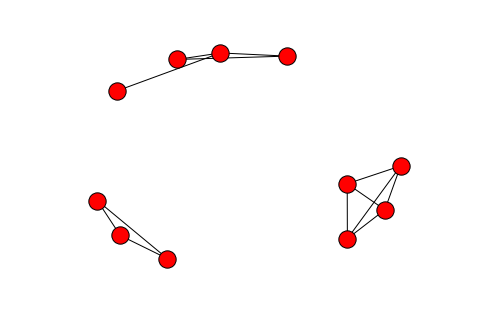

In [9]:
import networkx as nx
G=nx.Graph()


epsilon1=30
epsilon2=10

for i in range(len(lines)):
    G.add_node(i)


for i in range(len(lines)-1):
    for j in range(i+1,len(lines)):
        angle = ang(lines[i],lines[j])        
        #print(angle)
        if angle < epsilon2:
            distance = segmentsDistance(lines[i],lines[j])
            #print(distance)
            if distance < epsilon1:
                #print("combina ",i,j)
                G.add_edge(i,j)
        
nx.draw(G)

# que pasa en los casos en los que un segmento no se une con nada?
# los que estan completamente bien no salen?
# Sol, mete primero todos los nodos

combino

In [10]:
from networkx.algorithms import approximation as apxa

k_components = apxa.k_components(G)
k_components[1][0]

{0, 1, 2, 3}

In [11]:
import math

def pointDistance(p1, p2):
    dx = p1[0] - p2[0]
    dy = p1[1] - p2[1]
    return (dx*dx + dy*dy)**0.5

def combinaSegmentos(segmentosList):
    print("combina",segmentosList)
    Xs=list(map(lambda x:[x[0][0],x[1][0]],segmentosList))
    Ys=list(map(lambda x:[x[0][1],x[1][1]],segmentosList))
    xMax=np.max(Xs)
    yMax=np.max(Ys)
    xMin=np.min(Xs)
    yMin=np.min(Ys)
    if (xMax,yMax) in set(map(lambda x:x[0],segmentosList)):
        #print("devuelvo",((xMax,yMax),(xMin,yMin)))
        return ((xMax,yMax),(xMin,yMin))
    else:
        #print("devuelvo",((xMax,yMin),(xMin,yMax)))
        return ((xMax,yMin),(xMin,yMax))

segmentosDeVerdad = []
for i in range(len(k_components[1])):
    segmentos=list(map(lambda x:lines[x],k_components[1][i]))
    segmentosDeVerdad.append(combinaSegmentos(segmentos))
    
segmentosDeVerdad

combina [((15, 34), (10, 29)), ((24, 43), (4, 24)), ((50, 67), (25, 43)), ((55, 71), (49, 65))]
combina [((104, 36), (91, 20)), ((115, 48), (110, 42)), ((116, 50), (91, 19))]
combina [((128, 72), (162, 20)), ((129, 71), (163, 19)), ((145, 45), (151, 36)), ((128, 71), (138, 56))]


[((55, 71), (4, 24)), ((116, 50), (91, 19)), ((163, 19), (128, 72))]

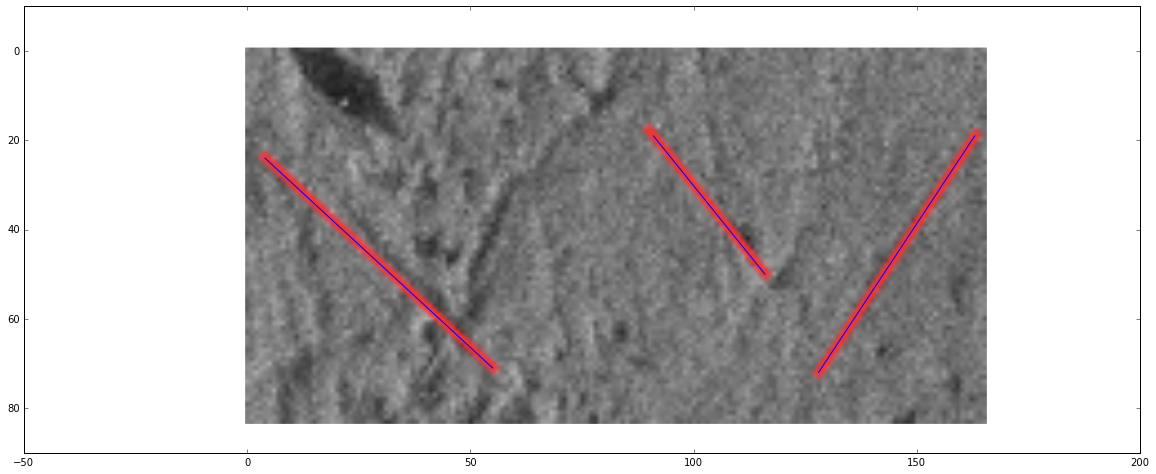

In [12]:
#Mostramos las lineas detectadas por nuestro procesamiento de datos.
plt.figure(figsize=(20, 20)) 

plt.imshow(img, cmap=plt.cm.gray)


for line in segmentosDeVerdad:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]),'b')